In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import math
import mat73
from datetime import datetime
import calendar
import allantools as al
import re
from scipy.stats import poisson
from scipy.stats import norm
import gmpy2 as gm
import mpmath as mp

In [2]:
mp.mp.dps = 50
fe3 = mp.mpf('642121496772645.10')
fe2 = mp.mpf('688358979309308.22')
R_Lange = mp.mpf('0.932829404530965376')


In [3]:
#--------------------define length of interrogation-------------
tInt = 2.015
#-----------------------------------------------------------

In [4]:
B = mp.mpf(31.275/(1e-9*0.59930*9.2740100657e-24/6.626e-34)) # in mu T
e2Zee = 52.14*B**2*1e-3
e3Zee = -2.082*B**2*1e-3
e2BBR = -517e-18*fe2
e3BBR = -73.6e-18*fe3
e2Quad = 0.049409
e3Quad = -0.049409/92.1
e2Shift = e2Zee+e2BBR+e2Quad
e3Shift = e3Zee+e3BBR+e3Quad

In [5]:
def lineFit(x,m,b):
    return m*x+b
def Gauss(x, A, sig, mu): 
    y = (A/np.sqrt(2*np.pi*sig**2))*np.exp((-(x-mu)**2)/(2.*sig**2)) 
    return y 

def linePts(x, y):
    n = np.size(x)
    fitYs = np.zeros(n)
    param, paramcov = curve_fit(lineFit,x,y, maxfev=5000)
    print(param[0])
    for ii in range(n):
        fitYs[ii] = lineFit(x[ii], param[0], param[1])
    return fitYs

def arbTimetoEpoch(t,t0): #takes t, time elapsed in s since t0 (a date time) and returns epoch time corresponding to t
    return t + t0.timestamp()

def nowToEpoch(time): #takes matlab "now" serial date number in days from Jan 1 0000 and converts to epoch time (s from 1970)
    dec = math.modf(time)[0]
    ing = int(math.modf(time)[1])
    t = datetime.fromordinal(ing-366).timestamp() + dec*24*60*60
    return t

In [6]:
def movingAvg(data, avgPts):
    if avgPts%2 == 1:
        n = np.size(data)
        avgData = np.zeros(n)
        for ii in range(avgPts//2):
            avgData[ii] = mp.fsum(data[:ii+avgPts//2+1])/np.size(data[:ii+avgPts//2+1])
            avgData[n-1-ii] = mp.fsum(data[n-ii-1-avgPts//2:])/np.size(data[n-ii-1-avgPts//2:])
        for ii in range(avgPts//2,n-avgPts//2,1):
            avgData[ii] = mp.fsum(data[ii-avgPts//2:ii+avgPts//2+1])/np.size(data[ii-avgPts//2:ii+avgPts//2+1])
        return avgData
    else: print("avgPts must be odd")

In [7]:
def importMoku(filename):
    lines=[]
    with open(filename, 'r') as file:
        for line in file:
            lines.append(line)
            #print(line.strip()) 
    lines = lines[10:]
    n = len(lines)
    ts = np.zeros(n)
    f871 = np.zeros(n)
    f933 = np.zeros(n)
    for ii in range(n):
        entries = lines[ii].split(',')
        ts[ii] = mp.mpf(entries[0])
        f871[ii] = mp.mpf(entries[2])
        f933[ii] = mp.mpf(entries[7])

    match = re.search(r"(\d{4})(\d{2})(\d{2})_(\d{2})(\d{2})(\d{2})", filename)
    dt = tuple(map(int, match.groups()))
    #print(dt)
    ts = arbTimetoEpoch(ts, datetime(*dt))
    return ts, f871, f933

def importMatlab(filename):
    mat = mat73.loadmat(filename)
    n=int(mat['currentdatapointnr'])
    ni = 0  #-----------cut off points while servo grabs---------------
    taoms=mat['aomfrequsmatrix'][ni:n-1,0]
    #print(ts[0])

    for ii in range(np.size(taoms)):
        taoms[ii] = nowToEpoch(taoms[ii])         #times now in epoch time
    fe2aom=mat['aomfrequsmatrix'][ni:n-1,1]
    fe3aom=mat['aomfrequsmatrix'][ni:n-1,4]
    return taoms, fe2aom, fe3aom

In [8]:
def trimData(ts, f933s, f871s, taoms, fe2aom, fe3aom):
    ni=0
    if ts[0]>taoms[0]:
        print("case 1")
        for ii in range(np.size(taoms)):
            if (taoms[ii] - tInt)>ts[0]: 
                ni=ii
                #print(ni)
                break
        #print(ni)
        taoms = taoms[ni:]
        fe2aom = fe2aom[ni:]
        fe3aom = fe3aom[ni:]
        #print("should be negative: ")
        print(ts[0]-taoms[0])
    else:
        print("case 2")
        # Cutting off first 30 points of aom data to give servo time to catch
        #--------------------------------------------------------
        nServo = 30
        taoms = taoms[nServo:]
        fe2aom = fe2aom[nServo:]
        fe3aom = fe3aom[nServo:]
        for ii in range(np.size(ts)):
            if ts[ii]>(taoms[0]-tInt):
                ni=ii
                #print(ni)
                break
        ts = ts[ni:]
        f871s = f871s[ni:]
        f933s = f933s[ni:]
        #print("should be negative: ")
        print(ts[0]-taoms[0])
    
    if ts[-1]>taoms[-1]:
        print("case 1")
        for ii in range(np.size(ts)):
            if ts[ii]>taoms[-1]:
                nf=ii
                break
        ts = ts[:nf+1]
        f871s = f871s[:nf+1]
        f933s = f933s[:nf+1]
        #print("should be positve: ")
        print(ts[-1]-taoms[-1])
    else:
        print("case 2")
        for ii in range(np.size(taoms)):
            if taoms[ii]>ts[-1]:
                nf=ii
                break
        #print(nf)
        taoms = taoms[:nf]
        fe2aom = fe2aom[:nf]
        fe3aom = fe3aom[:nf]
        #print("should be positve: ")
        print(ts[-1]-taoms[-1])
    return ts, f933s, f871s, taoms, fe2aom, fe3aom

In [9]:
def ratioCalc(mokuFile, aomFile, beatSign933, beatSign871, frep, Ncuts=None):
    ts, f871s, f933s  = importMoku(mokuFile)
    taoms, fe2aom, fe3aom  = importMatlab(aomFile)
    if Ncuts!=None:
        print("!!! Cutting off beat-note data at n= ", Ncuts)
        ts = ts[:Ncuts]
        f871s = f871s[:Ncuts]
        f933s = f933s[:Ncuts]
    print("Trimming.....")
    ts, f933s, f871s, taoms, fe2aom, fe3aom = trimData(ts, f933s, f871s, taoms, fe2aom, fe3aom)
    print("Done.")
    print("Start time: ", datetime.fromtimestamp(taoms[0]))
    print("End time: ", datetime.fromtimestamp(taoms[-1]))
    
    #Average beat note data
    n = np.size(taoms)
    f871adj = np.zeros(n)
    f933adj = np.zeros(n)
    ii = 0
    n1 = 0 
    n2 = 0
    while ii<n:
        while ts[n1] < (taoms[ii]-tInt):
            n1+=1
        while ts[n2] < taoms[ii]:
            n2 +=1
        f871adj[ii] = np.average(f871s[n1:n2])
        f933adj[ii] = np.average(f933s[n1:n2])
        ii+=1

    #Calculate comb teeth
    fceo = mp.mpf('70e6')
    print("------Comb Teeth------")
    print((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(161.5e6)/2)/frep)
    n871 = round((fe2/2-fceo + beatSign871*np.average(f871s)+80.0e6+(161.5e6)/2)/frep)
    print(n871)
    print((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+100e6/2)/frep)
    n933 = round((fe3/2-fceo + beatSign933*np.average(f933s)+80.0e6+100e6/2)/frep)
    print(n933)
    print("----------------------")

    #Calculate ratio
    nuA = fceo - beatSign871*f871adj
    nuB = (n871/n933)*(fceo-beatSign933*f933adj)
    nuC = nuA - nuB
    f933 = fe3/2 + np.average(fe3aom)/2 + 80e6
    ratio = nuC/f933+n871/n933
    R = (2-160e6/f933-fe3aom/f933-e3Shift/f933)/(2.*ratio-240e6/f933-fe2aom/f933-e2Shift/f933)
    return taoms, R

In [10]:
def concatRatio(dataSets, setNum):
    discreteRatio = np.zeros(setNum)
    Ratio = np.array([])
    durations = np.zeros(setNum)
    numPts = np.zeros(setNum)
    for ii in range(setNum):
        print("-----",ii,"-----")
        if len(dataSets[ii])==5:
            mokuFile, aomFile, beatSign933, beatSign871, frep = dataSets[ii]
            taoms, Rpts = ratioCalc(mokuFile, aomFile, beatSign933, beatSign871, frep)
        else:
            if len(dataSets[ii])!=6: print("Unexpected set element")
            mokuFile, aomFile, beatSign933, beatSign871, frep, Ncuts = dataSets[ii]
            taoms, Rpts = ratioCalc(mokuFile, aomFile, beatSign933, beatSign871, frep, Ncuts)
            
        Ratio = np.concatenate((Ratio, Rpts))
        discreteRatio[ii] = mp.fsum(Rpts)/np.size(Rpts)
        #npdiscreteRatio[ii] = np.average(Rpts)
        durations[ii] = taoms[-1]-taoms[0]
        numPts[ii] = np.size(taoms)
    return Ratio,  discreteRatio, durations, numPts

In [30]:
path = r"C:\Users\markl\Documents\Data\E2E3Ratio"

file1 = path+r"\MokuPhasemeterData_20250328_121044.csv"
file2 = path+r"\MokuPhasemeterData_20250331_113403.csv"
file3 = path+r"\MokuPhasemeterData_20250401_102033.csv"
file4 = path+r"\MokuPhasemeterData_20250402_131201.csv"
file5 = path+r"\MokuPhasemeterData_20250404_105752.csv"
file6 = path+r"\MokuPhasemeterData_20250404_124527.csv"
file7 = path+r"\MokuPhasemeterData_20250407_112146.csv"
file8 = path+r"\MokuPhasemeterData_20250407_120440.csv"
file9 = path+r"\MokuPhasemeterData_20250408_103336.csv"
file10 = path+r"\MokuPhasemeterData_20250408_135832.csv"
file11 = path+r"\MokuPhasemeterData_20250409_102919.csv"
file12 = path+r"\MokuPhasemeterData_20250410_104533.csv"
file13 = path+r"\MokuPhasemeterData_20250415_111036.csv"
file14 = path+r"\MokuPhasemeterData_20250416_112912.csv"

file1a = path+r"\aomfrequs-20250328_1_a.mat";
file2a = path+r"\aomfrequs-20250331_1_a.mat";
file3a = path+r"\aomfrequs-20250331_1.mat";
file4a = path+r"\aomfrequs-20253031_2_a.mat";
file5a = path+r"\aomfrequs-20250401_1_a.mat";
file6a = path+r"\aomfrequs-20250401_1.mat";
file7a = path+r"\aomfrequs-20250402_1.mat";
file8a = path+r"\aomfrequs-20250404_1.mat"
file9a = path+r"\aomfrequs-20250407_1.mat"
file10a = path+r"\aomfrequs-20250408_1.mat"
file11a = path+r"\aomfrequs-20250409_1.mat"
file12a = path+r"\aomfrequs-20250410_1.mat"
file13a = path+r"\aomfrequs-20250410_2.mat"
file14a = path+r"\aomfrequs-20250415_1.mat"
file15a = path+r"\aomfrequs-20250416_1.mat"
file16a = path+r"\aomfrequs-20250416_2.mat"

setNum = 18
sets = [()]*setNum
sets[0] = (file1, file1a, 1, 1, 249999914.714)
sets[1] = (file2, file2a,-1, 1, 249999762.665)
sets[2] = (file2, file3a,-1, 1, 249999762.665)
sets[3] = (file2, file4a,-1, 1, 249999762.665)
sets[4] = (file3, file5a, 1, 1, 249999914.712)
sets[5] = (file3, file6a, 1, 1, 249999914.712, 924245)
sets[6] = (file4, file7a, 1, 1, 250000066.767)
sets[7] = (file6, file8a,-1, 1, 249999762.665)
sets[8] = (file7, file9a,-1, 1, 249999963.430, 70781) #data has a spike, look into this
sets[9] = (file8, file9a, 1, 1, 249999914.712)
sets[10]= (file9, file10a,1, 1, 249999914.712, 352956)
sets[11]= (file10, file10a,1, 1, 249999914.712)
sets[12] = (file11, file11a, 1, 1,249999914.712)
sets[13] = (file12, file12a, 1, 1,249999914.712)
sets[14] = (file12, file13a, 1, 1,249999914.712)
sets[15] = (file13, file14a, 1, 1,249999914.712)
sets[16] = (file14, file15a, 1, 1,249999914.712)
sets[17] = (file14, file16a, 1, 1,249999914.712)

#mask = [0,0,1,1,1,0,1,1,1,1]
#mask= [1]*setNum
mask = [0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1]

sets = [t for t, m in zip(sets, mask) if m]
setNum = mask.count(1)

In [20]:
ratioCalc(file14, file16a, 1, 1,249999914.712)

Trimming.....
case 2
-2.013554811477661
case 1
0.03176259994506836
Done.
Start time:  2025-04-16 14:01:29.107003
End time:  2025-04-16 14:34:51.938998
------Comb Teeth------
1376719.0000215022023352761430671260639933768817815
1376719
1284244.0000197494885541792714908319490837423727292
1284244
----------------------


(array([1.74483369e+09, 1.74483369e+09, 1.74483369e+09, 1.74483370e+09,
        1.74483370e+09, 1.74483370e+09, 1.74483370e+09, 1.74483370e+09,
        1.74483371e+09, 1.74483371e+09, 1.74483371e+09, 1.74483371e+09,
        1.74483371e+09, 1.74483372e+09, 1.74483372e+09, 1.74483372e+09,
        1.74483372e+09, 1.74483372e+09, 1.74483373e+09, 1.74483373e+09,
        1.74483373e+09, 1.74483373e+09, 1.74483373e+09, 1.74483374e+09,
        1.74483374e+09, 1.74483374e+09, 1.74483374e+09, 1.74483374e+09,
        1.74483375e+09, 1.74483375e+09, 1.74483375e+09, 1.74483375e+09,
        1.74483375e+09, 1.74483376e+09, 1.74483376e+09, 1.74483376e+09,
        1.74483376e+09, 1.74483376e+09, 1.74483377e+09, 1.74483377e+09,
        1.74483377e+09, 1.74483377e+09, 1.74483377e+09, 1.74483378e+09,
        1.74483378e+09, 1.74483378e+09, 1.74483378e+09, 1.74483378e+09,
        1.74483379e+09, 1.74483379e+09, 1.74483379e+09, 1.74483379e+09,
        1.74483379e+09, 1.74483380e+09, 1.74483380e+09, 1.744833

In [31]:
Rs, discRs, Ts, Ns = concatRatio(sets , setNum)
Ravg = mp.fsum(Rs)/np.size(Rs)

----- 0 -----
Trimming.....
case 1
-9.448003768920898
case 1
0.0036385059356689453
Done.
Start time:  2025-03-31 11:34:12.448004
End time:  2025-03-31 15:01:57.192002
------Comb Teeth------
1376719.9999852012548112421399598704874488858893539
1376720
1284243.9999857314071844396047276560284219198738377
1284244
----------------------
----- 1 -----
Trimming.....
case 2
-1.987947940826416
case 1
0.00815582275390625
Done.
Start time:  2025-03-31 15:11:14.241002
End time:  2025-03-31 17:05:18.254996
------Comb Teeth------
1376719.9999851380504030331469880690186211394192317
1376720
1284243.9999856740710603646312293658723175026277265
1284244
----------------------
----- 2 -----
!!! Cutting off beat-note data at n=  924245
Trimming.....
case 1
-2.034003734588623
case 2
1.8064486980438232
Done.
Start time:  2025-04-01 10:20:35.034004
End time:  2025-04-01 18:57:23.676000
------Comb Teeth------
1376719.0000125328646284284148221666945911281695313
1376719
1284244.000011214216267268230001352998470196

In [591]:
avgRpts = movingAvg(Rs, 5001)

KeyboardInterrupt: 

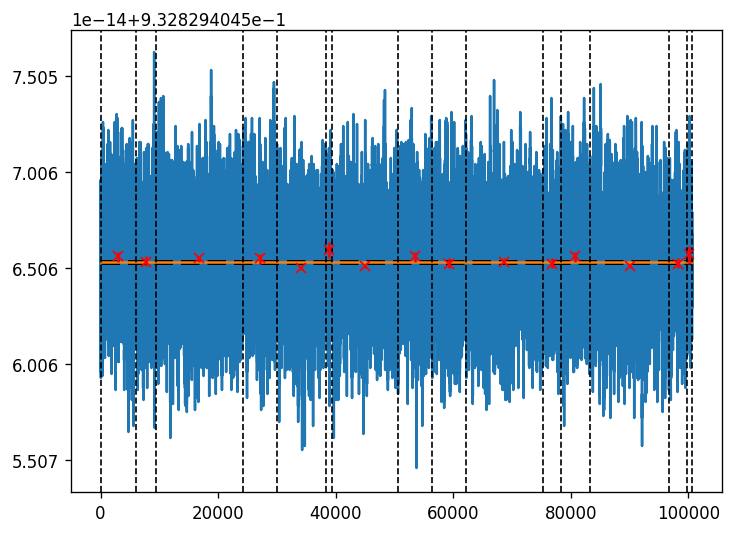

In [33]:
A = 1.9e-14

plt.figure(figsize=(7,5), dpi = 120)

plt.plot(Rs)
#plt.plot(avgRpts,zorder=9)
plt.plot([0, np.size(Rs)], [R_Lange, R_Lange], ls="--", color="black", linewidth=3)
plt.plot([0, np.size(Rs)], [Ravg, Ravg])

lim = 1.2e-14
plt.ylim([float(Ravg)-lim, float(Ravg)+lim])

xScatpts = np.zeros(np.size(Ns))
for ii in range(np.size(Ns)):
    xScatpts[ii] = np.sum(Ns[:ii]) + Ns[ii]/2
for ii in range(np.size(Ns)+1):
    ###plt.plot([float(Ravg)-lim, float(Ravg)+lim], [0,0], ls="--", c="bl")
    plt.plot([np.sum(Ns[:ii]),np.sum(Ns[:ii])], [float(Ravg)-lim, float(Ravg)+lim], lw=1, ls="--", c="black")

errors = np.zeros(np.size(discRs))
for ii in range(np.size(discRs)):
    errors[ii] = A/np.sqrt(Ts[ii])
    
plt.errorbar(xScatpts, discRs, yerr=errors,fmt="x", color="red", zorder=10)
plt.show()

In [34]:
err = A/np.sqrt(np.sum(Ts))
ratioOff = (Ravg-R_Lange)
print(float(ratioOff) ,u"\u00B1" , err)
print(Ravg)

1.893905629025844e-17 ± 4.133578425750301e-17
0.9328294045309653949390562902584399611329473003423


In [594]:
a = mp.mpf('0.9328294045309654280754928179082233433587555285953513441050368835568178')
b = mp.mpf('0.9328294045309654280743323113404752055153695974580529646114284757654119555028101')
R_Lange = mp.mpf('0.932829404530965376')

In [602]:
A = mp.mpf('0.9')
B = mp.mpf('0.900000000000000001')
A

mpf('0.8999999999999999999999999999999999999999999999999999999999999999999999964')

In [598]:
(a-R_Lange)*1e17

mpf('5.207549281790822334335875552859535134410503688355681780287664736838634626')

In [599]:
(b-R_Lange)*1e17

mpf('5.207433231134047520551536959745805296461142847576541195595479616811809924')

In [35]:
floatRs = np.array([float(pt) for pt in Rs])
rate = 1./tInt
taus,adev,adevErr,_ = al.adev(floatRs, rate, data_type="freq")

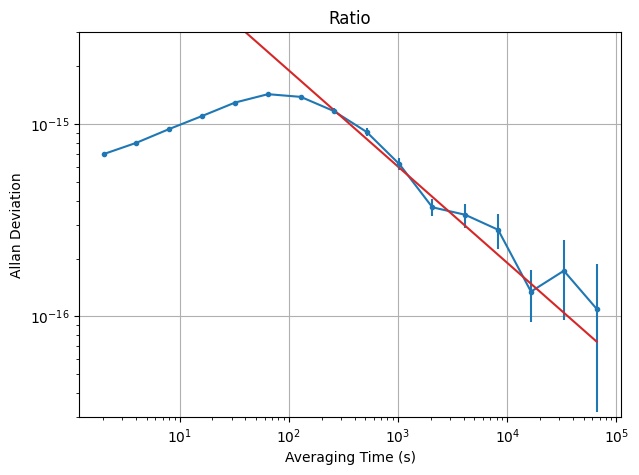

In [40]:
A = 1.9e-14

plt.figure(figsize=(7,5), dpi = 100)

plt.errorbar(taus, adev, yerr=adevErr, fmt=".", c="tab:blue")
plt.loglog(taus, adev, label="Ratio", c="tab:blue")
plt.loglog(taus, A/np.sqrt(taus), c="tab:red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allan Deviation")
plt.xlabel("Averaging Time (s)")
plt.title("Ratio")
plt.ylim([3e-17, 3e-15])
plt.grid()
plt.show()

In [ ]:
Ravg = mp.fsum(discRs)/np.size(discRs)
ns = np.linspace(1,np.size(discRs)+1,np.size(discRs))

plt.scatter(ns, 1e16*discRs, marker="+",s=60,color="red")
plt.plot([ns[0], ns[-1]], (1e16*R_Lange, 1e16*R_Lange),ls="-",color="black", label="Lange")
plt.plot([ns[0], ns[-1]], (1e16*Ravg, 1e16*Ravg), ls="--",color="red")

lim = 6.1
plt.ylim([1e16*float(Ravg)-lim, 1e16*float(Ravg)+lim])
plt.grid()
plt.show()

In [ ]:
dt = 0
for ii in range(np.size(taoms)-1):
    dt += taoms[ii+1]-taoms[ii]
dt = dt/np.size(taoms)
dt